# 머신러닝   
       
11주 1강: 로지스틱 회귀

이번 강의는 다중 클래스 회귀에 대해서 생각해 보겠습니다

## softmax 함수
* softmax 함수는 아래와 같이 구현할 수 있습니다. 

$\sigma(z_j)= \frac{exp(z_j)}{\sum_k exp(z_k)}$

In [2]:
import numpy as np

def softmax(values):
    array_values = np.exp(values)
    return array_values / np.sum(array_values)

values = [2, 1, 5, 0.5]
y = softmax(values) # array([0.04613281, 0.01697131, 0.92660226, 0.01029362])
y.sum()

np.float64(1.0)

## MNIST 다루기
* Modified National Institute of Standards and Technology database
* 손으로 쓴 숫자들로 이루어진 데이터입니다
* 일종의 ML계의 "초파리" !

### 데이터 불러오기
* datasets 모듈을 호출
* load_digits 함수로 딕셔너리 타입 데이터를 불러옵니다

In [3]:
from sklearn import datasets
digit_dataset = datasets.load_digits()
digit_dataset.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
type(digit_dataset)

sklearn.utils._bunch.Bunch

In [5]:
print(digit_dataset["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

* 데이터의 형태를 봅시다.

In [6]:
digit_dataset["images"].shape

(1797, 8, 8)

In [16]:
digit_dataset["target"]

array([0, 1, 2, ..., 8, 9, 8])

In [17]:
digit_dataset["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

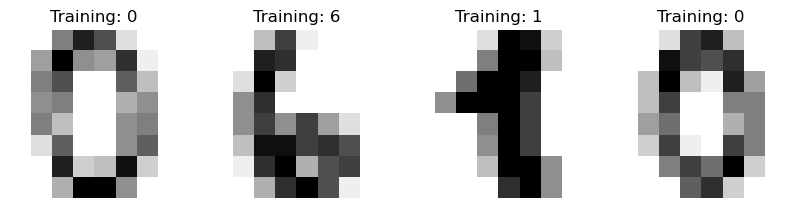

In [18]:
import matplotlib.pyplot as plt
from random import randint
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))  # (1)

for ax in axes:  # (2)
    num = randint(1, 1000)  # (3)
    image = digit_dataset["images"][num]
    label = digit_dataset["target"][num]    
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')  # (4)
    ax.set_title('Training: %i' % label)

In [19]:
# 데이터가 8×8 행렬이므로 2D 이미지로 표현되었지만 다음 코드와 같이 총 64개의 피쳐(feature)를 가진 하나의 데이터로 쓸수 있습니다 
digit_dataset["data"][0].shape

(64,)

In [20]:
digit_dataset["data"][0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [21]:
# 이는 아래와 동등합니다.
digit_dataset["images"][0].reshape(-1)

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

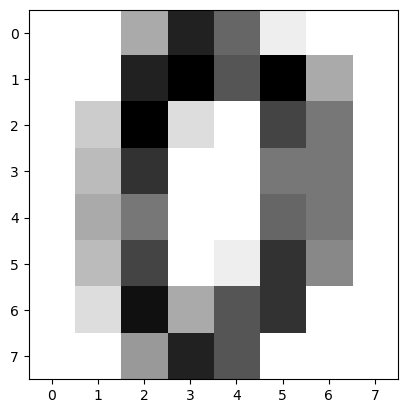

In [22]:
# 위 숫자와 아래 그림을 비교해 봅시다.
plt.imshow(digit_dataset["images"][0], cmap=plt.cm.gray_r, interpolation='nearest')

### 데이터 전처리
* 이미 잘 처리된 데이터니 train-test split 정도만 해주면 됩니다 

In [23]:
from sklearn.model_selection import train_test_split

X = digit_dataset["data"]   # (1)
y = digit_dataset["target"]   # (1)
X_train, X_test, y_train, y_test = train_test_split(X, y)   # (2)

In [24]:
len(X_train)/len(X)

0.7495826377295493

### 모델 만들기
* ovr : 클래스 모드를 모두 이진모델로 만들어 학습 (one-vs-rest) 
   * 각 클래스에 대해 하나의 로지스틱 회귀 모델을 학습하고, 해당 클래스를 positive 클래스로, 다른 모든 클래스를 negative 클래스로 학습합니다. 
   * 각 클래스의 확률을 예측하고 가장 높은 확률을 가진 클래스를 예측 클래스로 선택합니다.
* multinomial : 소프트맥스 함수를 사용하여 계산하는 방식. 경사하강법의 매개변수 solver를 sag으로 변경
   * 각 클래스의 확률을 예측하고 가장 높은 확률을 가진 클래스를 예측 클래스로 선택합니다.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# 교과서 코드는 max_iter가 기본값 (100)으로 되어있습니다. 성능 차이가 크진 않지만 warning 이 뜨니 좀 늘립시다. 
# 또한 scikit-learn 1.5부터는 LogisticRegression에서 multi_class라는 파라미터는 쓰이지 않습니다. 

# 아래가 원 교과서 코드입니다.
#logreg_ovr = LogisticRegression(multi_class="ovr", max_iter=1000) 
#logreg_softmax = LogisticRegression(multi_class="multinomial", solver="sag", max_iter=1000)

# 이제는 이렇게 쓰셔야 합니다
logreg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
logreg_softmax = LogisticRegression(solver="sag", max_iter=1000)

# sag = Stochastic Average Gradient Descent
# 두 개의 차이: 
#   ovr: 클래스별로 독립적인 모델을 만듭니다
#   softmax: 하나의 통합 모델

logreg_ovr.fit(X_train, y_train)
logreg_softmax.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='sag')

* One-vs-one 도 한번 해 봅시다

In [26]:
from sklearn.multiclass import OneVsOneClassifier

logreg_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
logreg_ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000))

### 성능 측정하기
* 일반적으로 다중클래스 분류도 혼동행렬을 쓸 수 있습니다.
* 실제 클래스와 예측한 값을 행렬 형태로 표현하면 됩니다.


In [29]:
from sklearn.metrics import confusion_matrix
#y_pred = logreg_ovr.predict(X_test).copy()
#y_pred = logreg_ovo.predict(X_test).copy()
y_pred = logreg_softmax.predict(X_test).copy()
# 다른 모델로도 한 번 해 보세요.
y_true = y_test.copy()

confusion_matrix(y_true, y_pred)

array([[36,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 43,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2, 48,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 51,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 42,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 44,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 42,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  1,  0, 55,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 36,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  1, 43]])

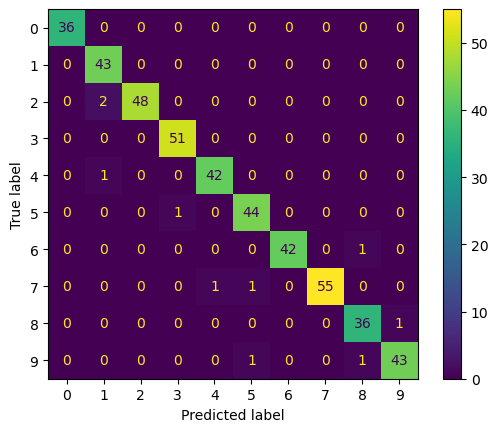

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

confumat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
confumat.plot()

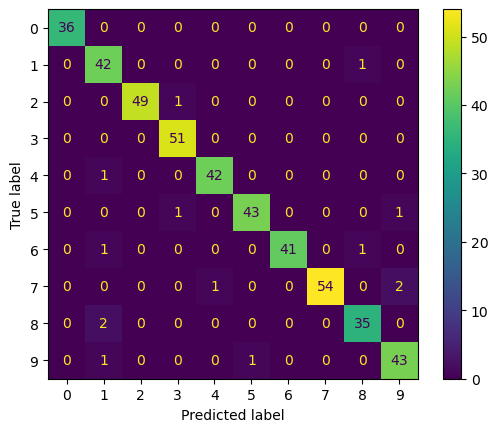

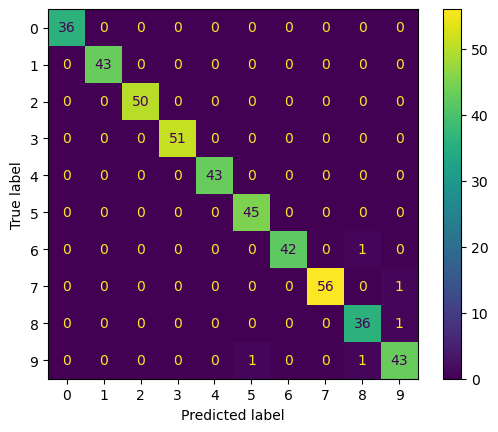

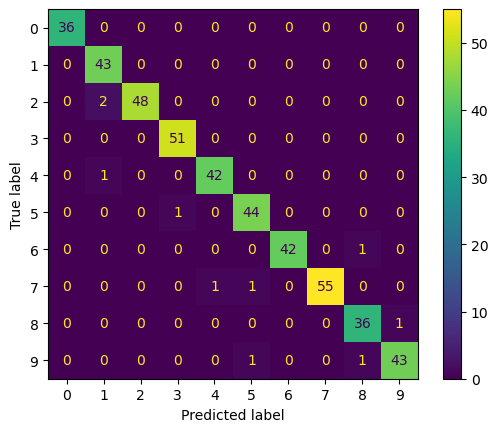

In [31]:
from sklearn.metrics import confusion_matrix
y_pred_ovr = logreg_ovr.predict(X_test).copy()
y_pred_ovo = logreg_ovo.predict(X_test).copy()
y_pred_soft = logreg_softmax.predict(X_test).copy()
# 다른 모델로도 한 번 해 보세요.
y_true = y_test.copy()

from sklearn.metrics import ConfusionMatrixDisplay

confumat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_ovr))
confumat.plot()

confumat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_ovo))
confumat.plot()

confumat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_soft))
confumat.plot()

* 클래스별로 분류 성능을 수치화해서 보려면 `sklearn.metrics.classification_report`을 쓰면 됩니다


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
print("ovr")
print(classification_report(y_true, y_pred_ovr))
print("ovo")
print(classification_report(y_true, y_pred_ovo))
print("softmax")
print(classification_report(y_true, y_pred_soft))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.93      1.00      0.97        43
           2       1.00      0.96      0.98        50
           3       0.98      1.00      0.99        51
           4       0.98      0.98      0.98        43
           5       0.96      0.98      0.97        45
           6       1.00      0.98      0.99        43
           7       1.00      0.96      0.98        57
           8       0.95      0.97      0.96        37
           9       0.98      0.96      0.97        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

ovr
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.89      0.98      0.93        43
           2       1.00      0.98      0.99        50
           3       0

* 다중 분류는 평균적인 분류율을 가지고 성능을 논할 때가 많습니다. 크게는 macro average와 micro average 로 나눕니다.
* Macro Average:
  * 각 클래스별로 지표를 계산한 후 평균을 냄
  * 모든 클래스에 동일한 가중치를 부여
  * 클래스 불균형이 있을 때도 각 클래스를 동등하게 취급
  * (클래스1_지표 + 클래스2_지표 + ... + 클래스N_지표) / N

* Micro Average:
  * 전체 데이터에 대해 한 번에 지표를 계산
  * 각 샘플에 동일한 가중치를 부여
  * 클래스 불균형이 있을 때 더 많은 샘플을 가진 클래스에 높은 가중치 부여
  * 데이터를 하나로 모아서 계산하므로 클래스 크기의 영향을 받음
  * 예시: 전체중 맞은 갯수 / 전체 데이터 갯수
  
* 클래스가 균형적일 때:
  * Macro와 Micro average가 비슷한 값을 보임: 어떤 것을 사용해도 무방
  * MNIST가 딱 이런 케이스입니다.

* 클래스가 불균형할 때:
  * Macro average: 소수 클래스의 성능도 중요할 때
  * Micro average: 다수 클래스의 성능이 더 중요할 때

In [36]:
result = confusion_matrix(y_true, y_pred)
result.diagonal().sum() / result.sum(axis=0).sum()

np.float64(0.9777777777777777)

In [38]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average="micro") 

np.float64(0.9777777777777777)

In [39]:
precision_score(y_true, y_pred, average="macro") 

np.float64(0.9773458912967188)

In [40]:
precision_score(y_true, y_pred, average=None) # 이건 클래스별로 따로 보여줍니다.

array([1.        , 0.93478261, 1.        , 0.98076923, 0.97674419,
       0.95652174, 1.        , 1.        , 0.94736842, 0.97727273])

In [41]:
precision_score(y_true, y_pred, average=None).mean() # 이 값이 macro average와 같아집니다.

np.float64(0.9773458912967188)

## ROC Curve
* TPR(True Positive Rate)과 FPR(False Positive Rate)을 각각 y축, x축에 나타내어 그래프를 그립니다.
### 구현하기
* 정답 y 값과 각 항목별 예측 확률을 scores에 저장
* ROC 커브 함수인 roc_curve로 fpr, tpr, thresholds 반환

In [43]:
import numpy as np
from sklearn import metrics

y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)

# fpr - array([0. , 0. , 0.5, 0.5, 1. ])
# tpr - array([0. , 0.5, 0.5, 1. , 1. ])
# thresholds - array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])

In [44]:
fpr

array([0. , 0. , 0.5, 0.5, 1. ])

In [45]:
tpr

array([0. , 0.5, 0.5, 1. , 1. ])

In [46]:
thresholds

array([ inf, 0.8 , 0.4 , 0.35, 0.1 ])

In [47]:
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

np.float64(0.75)

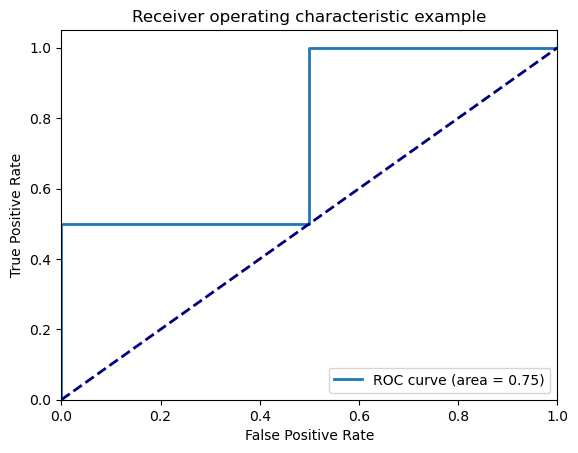

In [48]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* `sklearn.datasets.make_classification` 은 가상의 분류 데이터를 만들어줍니다. 
* 아래 가상 데이터로 만든 코드를 한 번 봅시다 (powered by Claude.ai)

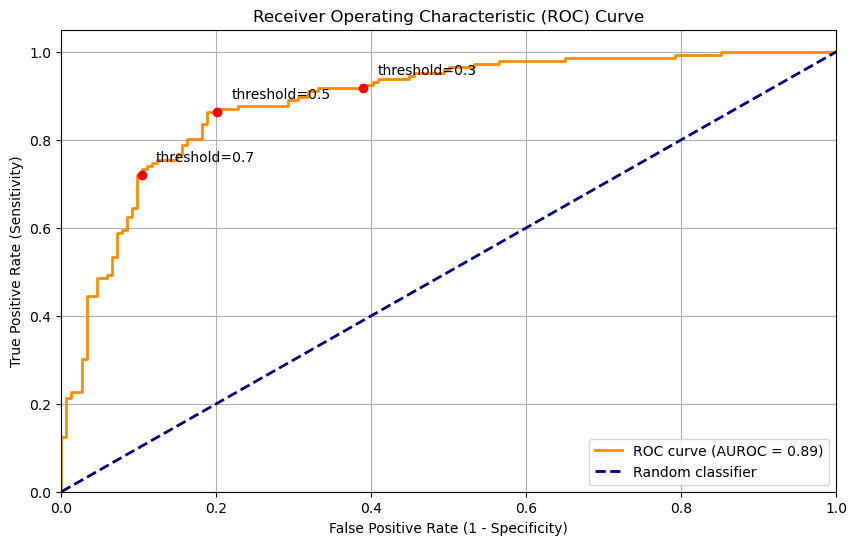


임계값별 성능 지표:
Threshold | False Positive Rate | True Positive Rate
--------------------------------------------------
0.3       | 0.390              | 0.918
0.5       | 0.201              | 0.863
0.7       | 0.104              | 0.719


In [51]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 샘플 데이터 생성
X, y = make_classification(
    n_samples=1000,  # 샘플 개수
    n_classes=2,     # 이진 분류
    n_features=20,   # 특성 개수
    n_informative=15,# 정보를 가진 특성 개수
    random_state=42
)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 확률 계산
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ROC 커브 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# 임계값 표시 (0.3, 0.5, 0.7)
threshold_points = [0.3, 0.5, 0.7]
for threshold in threshold_points:
    # 가장 가까운 임계값 찾기
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.plot(fpr[idx], tpr[idx], 'ro')
    plt.annotate(f'threshold={threshold:.1f}', 
                (fpr[idx], tpr[idx]), 
                xytext=(10, 10), 
                textcoords='offset points')

plt.show()

# 주요 임계값들에 대한 성능 지표 출력
print("\n임계값별 성능 지표:")
print("Threshold | False Positive Rate | True Positive Rate")
print("-" * 50)
for threshold in threshold_points:
    idx = np.argmin(np.abs(thresholds - threshold))
    print(f"{threshold:.1f}       | {fpr[idx]:.3f}              | {tpr[idx]:.3f}")

In [ ]:
for idx, threshold in enumerate(thresholds):
    print(f"{threshold:.5f}       | {fpr[idx]:.3f}              | {tpr[idx]:.3f}")

### 다음 주
* Naïve Bayes 분류기를 배웁니다.